In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data


In [11]:
df = pd.read_csv("../data/TeleAntiFraud/cleaned_conversations.csv")
df

,conversation_id,label,left_text,right_text,full_text,fraud_type,perp_text_en
0,tts_test1,NEG,喂，你好 我是来自金融投资咨询中心的小李，我们注意到你最近在寻找投资机会。 太好了，我们有一...,嗯，你好 哦，是吗，我确实有点兴趣。 嗯，听起来不错，具体是什么项目呢？ 数字货币啊，听起来...,喂，你好 嗯，你好 我是来自金融投资咨询中心的小李，我们注意到你最近在寻找投资机会。 哦，是...,Investment Scam,"Hello, hello, I am Xiao Li from the Financial ..."
1,tts_test10,NEG,喂，你好，我是中行渠道部的小李。 我们这边有一个特别优惠的贷款产品，利率特别低，只有两厘，你...,你好，有什么事情吗？ 可以啊，这个贷款怎么申请？ 下载APP？我怕下载了以后有问题。 那我需...,喂，你好，我是中行渠道部的小李。 你好，有什么事情吗？ 我们这边有一个特别优惠的贷款产品，利...,Loan Scam,"Hello, hello, I’m Xiao Li from the Channel Dep..."
2,tts_test100,NEG,喂，你好，这边是全国快递客服专线，我是客服专员小李。 你的一个快递包裹在运输途中不慎丢失，我...,你好，有什么事吗？ 真的吗？那太感谢你了。 好的，我的银行卡号是六二二八四八零零零零零零零零...,喂，你好，这边是全国快递客服专线，我是客服专员小李。 你好，有什么事吗？ 你的一个快递包裹在...,Telecom Scam,"Hello, hello, this is the national express cus..."
3,tts_test1000,NEG,喂，你好，我是农商银行的张经理。 根据你名下的华瑞精密模具厂的营业执照，我们银行可以为你提供...,你好，张经理。 啊，这个暂时不需要。 嗯，我再考虑考虑。 嗯，好的。 好的，我知道了。,喂，你好，我是农商银行的张经理。 你好，张经理。 根据你名下的华瑞精密模具厂的营业执照，我们...,Loan Scam,"Hello, hello, I am Manager Zhang from Rural Co..."
4,tts_test1001,NEG,你好，请问是张华吗？ 我是京东金融的客服专员，我们注意到你之前有浏览过我们的贷款产品，现在我...,是我，你是谁啊？ 贷款？我现在手头还行，暂时不考虑。 那听起来不错，但我在其他银行也有贷款，...,你好，请问是张华吗？ 是我，你是谁啊？ 我是京东金融的客服专员，我们注意到你之前有浏览过我们...,Loan Scam,"Hello, is this Zhang Hua? I am a customer serv..."
...,...,...,...,...,...,...,...
8897,tts_test2410,POS,喂，你到哪里了？ 我还在公交站等车，你出来往北走，看到第一个十字路口右转。 对，看到超市右转...,我刚出地铁站，你呢？ 好的，那里有个大超市，我不会错过的。 明白了，你到的时候先在咖啡店等我...,喂，你到哪里了？ 我刚出地铁站，你呢？ 我还在公交站等车，你出来往北走，看到第一个十字路口右...,NaN,"Hello, where have you been? I'm still waiting ..."
8898,tts_test2411,POS,喂，你好 我在小区门口，准备去超市买点东西。 好的，帮我带点苹果吧，谢谢了。 你上次说的那个...,你好，你在哪呢？ 好，我等一下就下来，顺便帮你带点水果。 没问题，苹果我这就去选。 看了，挺...,喂，你好 你好，你在哪呢？ 我在小区门口，准备去超市买点东西。 好，我等一下就下来，顺便帮你...,NaN,"Hello, hello. I'm at the gate of the community..."
8899,tts_test2412,POS,喂，你好，我是社区服务中心的小张，你看这周末有没有空，我们有个公益活动，希望你能来参加。 是...,好，公益活动听起来不错，是什么活动呢？ 好啊，我挺感兴趣的，具体是什么时间呢？ 那我应该几点...,喂，你好，我是社区服务中心的小张，你看这周末有没有空，我们有个公益活动，希望你能来参加。 好...,NaN,"Hello, hello, I am Xiao Zhang from the communi..."
8900,tts_test2413,POS,喂，你好，我是小王，你们店里有没有素菜炒面？ 好的，我想点一份，还有你们的辣度可以调整吗？ ...,你好，小王，我们这里有素菜炒面，还蛮受欢迎的，你要不要试试？ 可以的，我们提供微辣、中辣和特...,喂，你好，我是小王，你们店里有没有素菜炒面？ 你好，小王，我们这里有素菜炒面，还蛮受欢迎的，...,NaN,"Hello, hello, I’m Xiao Wang. Do you have veget..."


100%|██████████| 8902/8902 [03:19<00:00, 44.52it/s]


   row      entity        label
0    0       Hello  PERSON_NAME
1    0        Xiao  PERSON_NAME
2    0          Li  PERSON_NAME
3    0   Financial  PERSON_NAME
4    0  Investment  PERSON_NAME


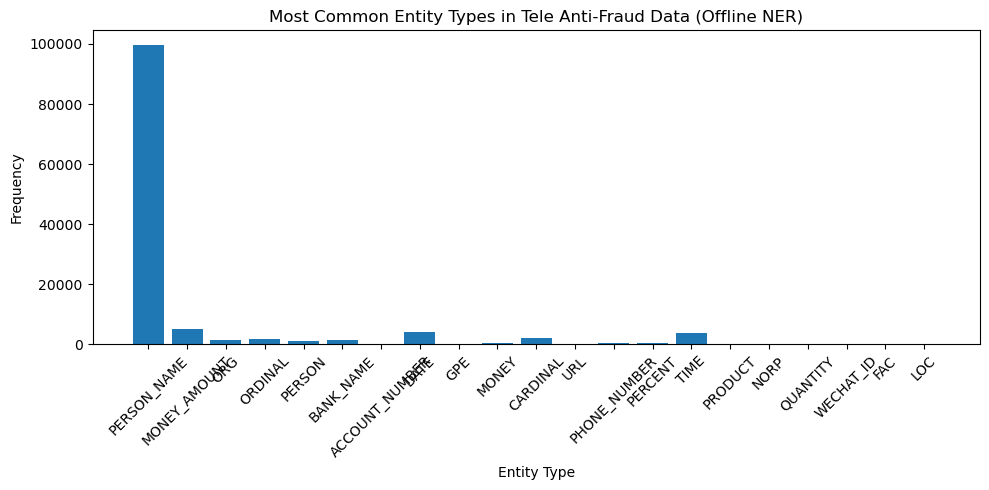

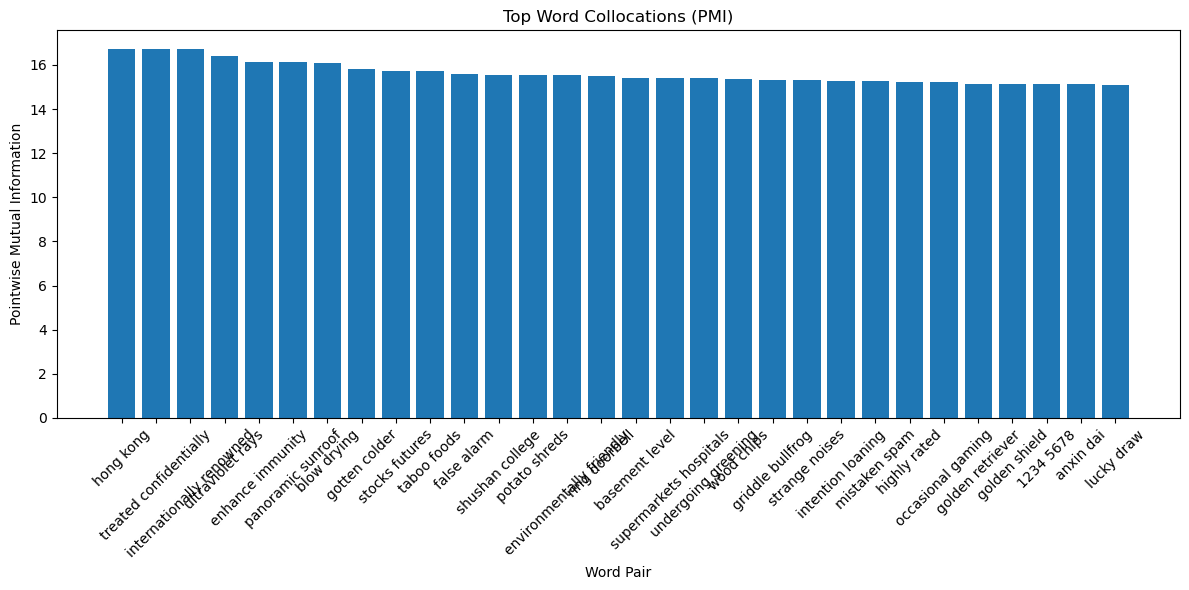


Top 5 entities per type:

label
ACCOUNT_NUMBER    [(13800138000, 71), (13812345678, 20), (123456...
BANK_NAME         [(Bank, 1341), (Finance, 52), (Banking, 7), (H...
CARDINAL          [(two, 386), (one, 359), (four, 350), (more th...
DATE              [(tomorrow, 958), (today, 441), (the weekend, ...
FAC               [(the park gate, 15), (the south gate, 11), (t...
GPE               [(XX, 52), (JD, 33), (n’t, 9), (’s, 8), (nb_ba...
LOC                                [(the east gate, 1), (mango, 1)]
MONEY             [(more than, 80), (up to, 41), (two hundred yu...
MONEY_AMOUNT      [(3, 323), (2, 290), (10, 286), (12, 247), (50...
NORP                               [(’s, 2), (JETCO, 1), (scan, 1)]
ORDINAL           [(first, 1449), (second, 60), (third, 47), (si...
ORG               [(APP, 1321), (ICBC, 22), (the ‘, 8), (JD.com,...
PERCENT           [(as low as, 96), (up to, 95), (only two perce...
PERSON            [(I’m, 1128), (goodbye, 19), (garlic broccoli,...
PERSON_NAME    

In [ ]:
import pandas as pd
import spacy
from spacy.pipeline import EntityRuler
import re
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

# ===== STEP 1: Load your translated dataset =====
# Ensure there's a column 'conversation' or equivalent
if "conversation" not in df.columns:
    df["conversation"] = df["perp_text_en"]

# ===== STEP 2: Define regex patterns and Tokenize =====
patterns = [
    {"label": "PHONE_NUMBER", "pattern": r"\+?\d[\d\s\-]{7,15}"},
    {"label": "MONEY_AMOUNT", "pattern": r"\$?\d+(?:,\d{3})*(?:\.\d{2})?\s?(?:USD|RMB|dollars|yuan|¥)?"},
    {"label": "APP_NAME", "pattern": r"\b[A-Z][A-Za-z0-9_-]{2,}\s?(?:app|App|APP)\b"},
    {"label": "WECHAT_ID", "pattern": r"(?:wechat|WeChat|微信)[:：]?\s?[A-Za-z0-9_-]{3,}"},
    {"label": "URL", "pattern": r"https?://[^\s]+|www\.[^\s]+"},
    {"label": "BANK_NAME", "pattern": r"(?:Bank|银行|金融|Finance|Investment Center|Consulting Center)"},
    {"label": "PERSON_NAME", "pattern": r"(?:Mr\.|Ms\.|Dr\.)?\s?[A-Z][a-z]+(?:\s[A-Z][a-z]+)?"},
    {"label": "ACCOUNT_NUMBER", "pattern": r"\b\d{8,12}\b"},
    {"label": "FRAUD_TRIGGER", "pattern": r"(?:investment opportunity|safe returns|download app|guaranteed profit|verify your identity|transfer money)"}
]

stop_words = set(stopwords.words('english'))

def clean_and_tokenize(text):
    text = re.sub(r"[^A-Za-z0-9\s]", " ", str(text))
    tokens = [t.lower() for t in nltk.word_tokenize(text) if t.lower() not in stop_words and len(t) > 2]
    return tokens

df["tokens"] = df["conversation"].apply(clean_and_tokenize)

# ===== STEP 3: Collocation (word pair co-occurrence) =====
all_tokens = [token for tokens in df["tokens"] for token in tokens]
bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(all_tokens)
finder.apply_freq_filter(3)  # only keep pairs that appear at least 3 times
bigrams_scored = finder.score_ngrams(bigram_measures.pmi)

colloc_df = pd.DataFrame(bigrams_scored, columns=["bigram", "pmi"])
colloc_df["bigram_str"] = colloc_df["bigram"].apply(lambda x: " ".join(x))
colloc_df = colloc_df.sort_values("pmi", ascending=False).head(30)

# ===== STEP 3: Create spaCy pipeline =====
nlp = spacy.load("en_core_web_sm")

# Add custom EntityRuler
ruler = nlp.add_pipe("entity_ruler", before="ner")

# Convert regex patterns into spaCy-friendly ones
spacy_patterns = []
for p in patterns:
    spacy_patterns.append({"label": p["label"], "pattern": [{"TEXT": {"REGEX": p["pattern"]}}]})

ruler.add_patterns(spacy_patterns)

# ===== STEP 4: Apply NER to each conversation =====
all_entities = []
for idx, text in tqdm(enumerate(df["conversation"]), total=len(df)):
    doc = nlp(str(text))
    for ent in doc.ents:
        all_entities.append({
            "row": idx,
            "entity": ent.text,
            "label": ent.label_
        })

entities_df = pd.DataFrame(all_entities)
entities_df.to_csv("../data/TeleAntiFraud/tele_antifraud_entities_offline.csv", index=False)
print(entities_df.head())

# ===== STEP 5: Aggregate and visualize =====
label_counts = Counter(entities_df["label"])
plt.figure(figsize=(10, 5))
plt.bar(label_counts.keys(), label_counts.values())
plt.title("Most Common Entity Types in Tele Anti-Fraud Data (Offline NER)")
plt.xlabel("Entity Type")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
plt.bar(colloc_df["bigram_str"], colloc_df["pmi"])
plt.xticks(rotation=45)
plt.xlabel("Word Pair")
plt.ylabel("Pointwise Mutual Information")
plt.title("Top Word Collocations (PMI)")
plt.tight_layout()
plt.show()

# Optional: show top entities per type
top_entities = (
    entities_df.groupby("label")["entity"]
    .apply(lambda x: Counter(x).most_common(5))
)
print("\nTop 5 entities per type:\n")
print(top_entities)


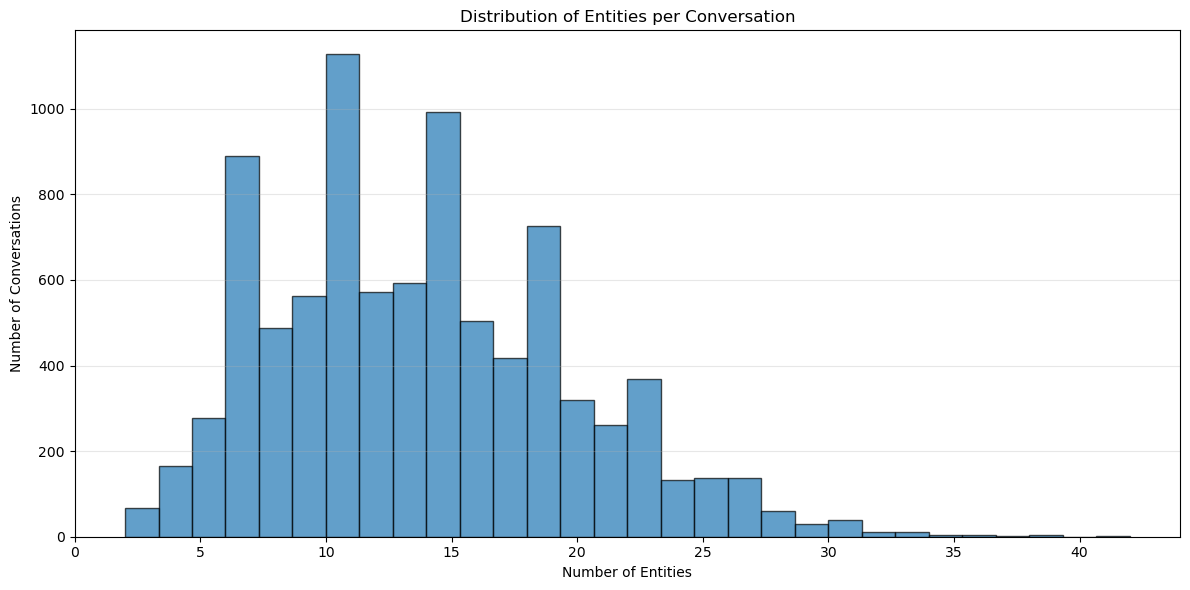

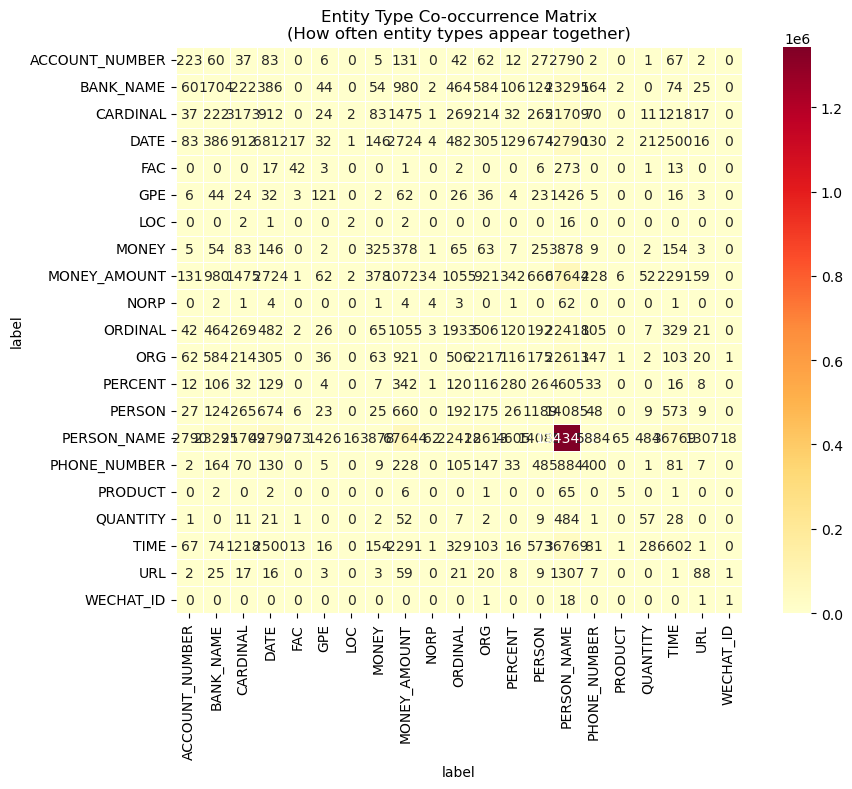

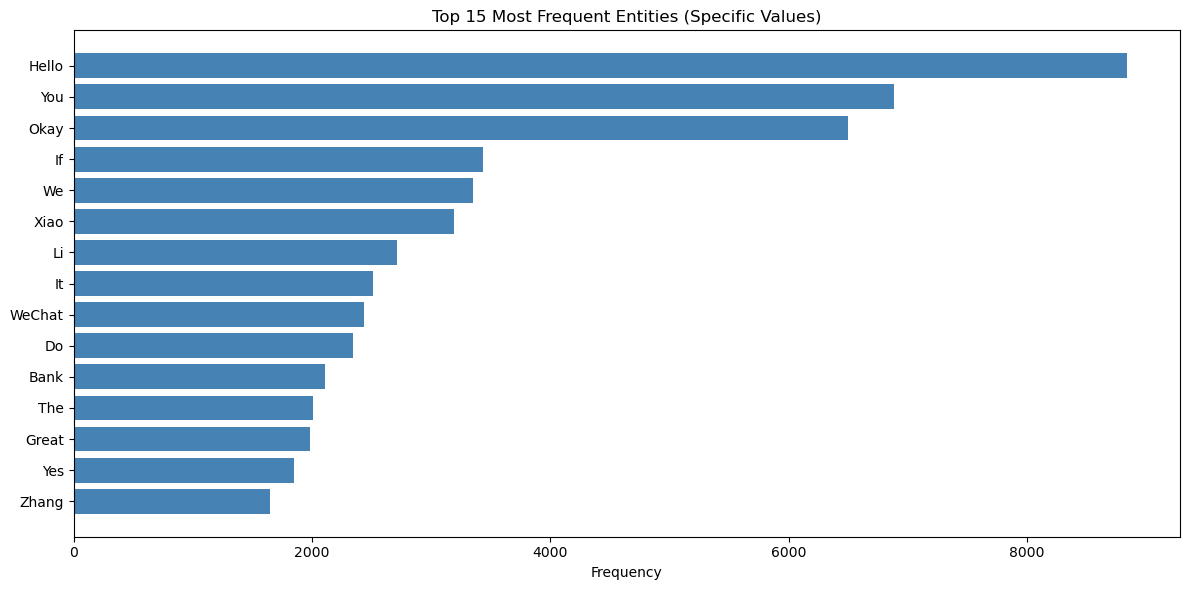

<Figure size 1400x600 with 0 Axes>

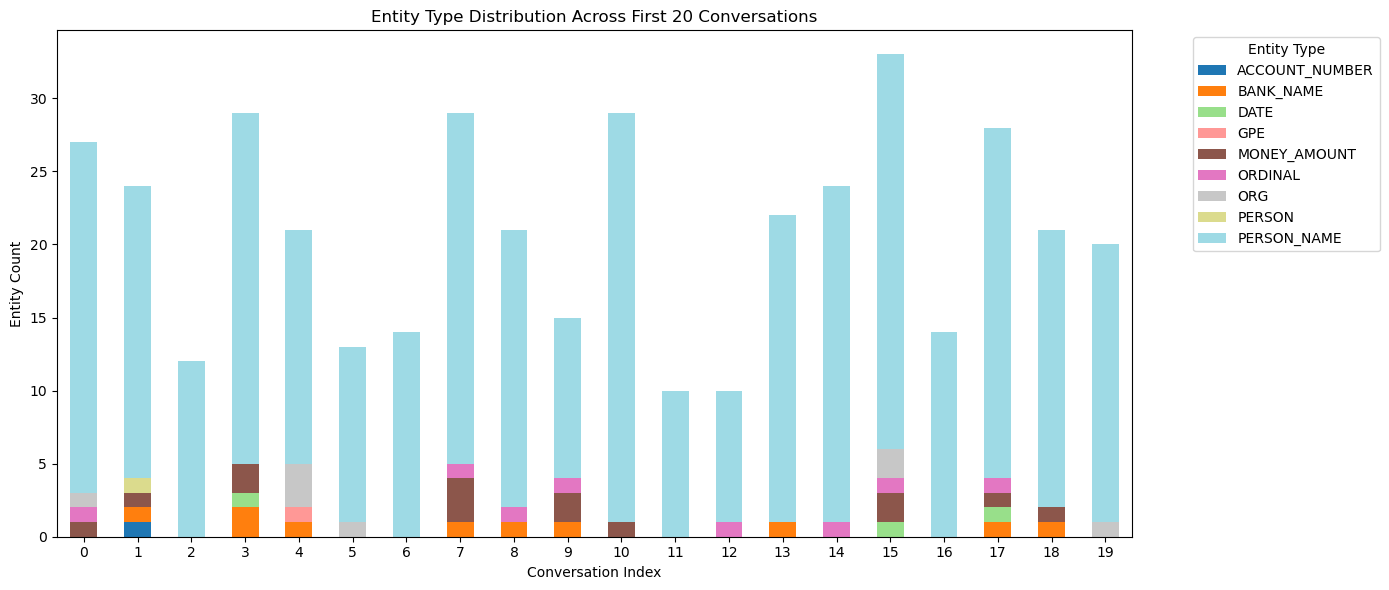

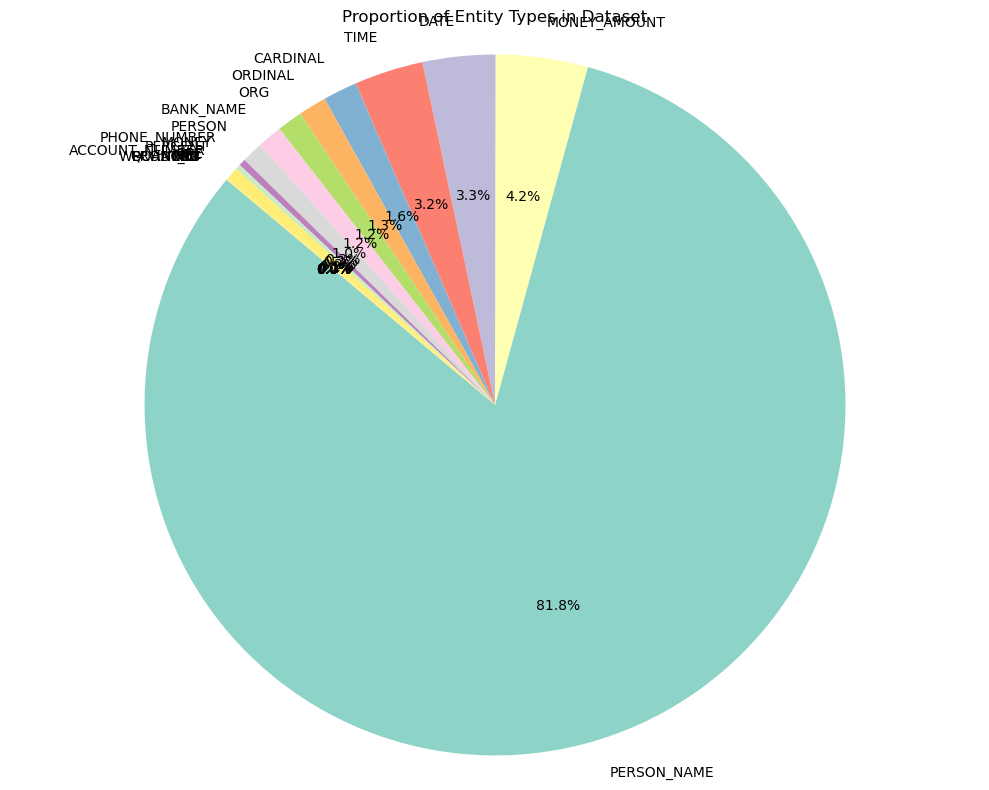

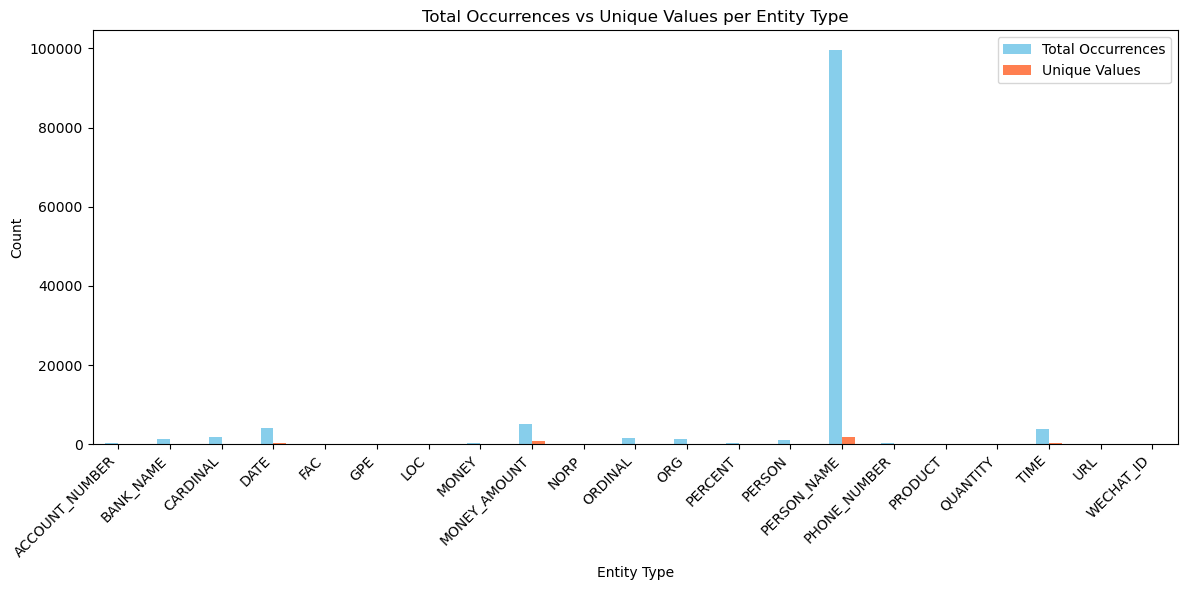


✓ All visualizations generated successfully!


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Assuming entities_df and df are already loaded from your previous code

# ===== VISUALIZATION 1: Entity Distribution by Row/Conversation =====
# Shows which conversations have the most entities
plt.figure(figsize=(12, 6))
entities_per_row = entities_df.groupby("row").size()
plt.hist(entities_per_row, bins=30, edgecolor='black', alpha=0.7)
plt.title("Distribution of Entities per Conversation")
plt.xlabel("Number of Entities")
plt.ylabel("Number of Conversations")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ===== VISUALIZATION 2: Heatmap of Entity Co-occurrence =====
# Shows which entity types tend to appear together in the same conversation
entity_pivot = entities_df.groupby(['row', 'label']).size().unstack(fill_value=0)
entity_cooccurrence = entity_pivot.T.dot(entity_pivot)

plt.figure(figsize=(10, 8))
sns.heatmap(entity_cooccurrence, annot=True, fmt='d', cmap='YlOrRd', 
            square=True, linewidths=0.5)
plt.title("Entity Type Co-occurrence Matrix\n(How often entity types appear together)")
plt.tight_layout()
plt.show()

# ===== VISUALIZATION 3: Top 10 Most Frequent Specific Entities =====
# Shows the actual entities that appear most often (not just types)
top_entities_overall = Counter(entities_df["entity"]).most_common(15)
entities_list, counts_list = zip(*top_entities_overall)

plt.figure(figsize=(12, 6))
plt.barh(range(len(entities_list)), counts_list, color='steelblue')
plt.yticks(range(len(entities_list)), entities_list)
plt.xlabel("Frequency")
plt.title("Top 15 Most Frequent Entities (Specific Values)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ===== VISUALIZATION 4: Entity Types Stacked Bar Chart by Sample =====
# Shows entity type distribution across first 20 conversations
sample_rows = entities_df[entities_df['row'] < 20]
pivot_data = sample_rows.groupby(['row', 'label']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 6))
pivot_data.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='tab20')
plt.title("Entity Type Distribution Across First 20 Conversations")
plt.xlabel("Conversation Index")
plt.ylabel("Entity Count")
plt.legend(title="Entity Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# ===== VISUALIZATION 5: Proportion of Each Entity Type (Pie Chart) =====
label_counts = entities_df['label'].value_counts()

plt.figure(figsize=(10, 8))
colors = plt.cm.Set3(range(len(label_counts)))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=colors)
plt.title("Proportion of Entity Types in Dataset")
plt.axis('equal')
plt.tight_layout()
plt.show()

# ===== VISUALIZATION 6: Entity Type Timeline (if you have timestamps) =====
# If your df has a timestamp column, uncomment and modify this:
# df['date'] = pd.to_datetime(df['timestamp'])  # adjust column name
# entities_with_dates = entities_df.merge(df[['date']], left_on='row', right_index=True)
# entities_with_dates['date'] = entities_with_dates['date'].dt.date
# 
# entity_timeline = entities_with_dates.groupby(['date', 'label']).size().unstack(fill_value=0)
# 
# plt.figure(figsize=(14, 6))
# entity_timeline.plot(kind='line', figsize=(14, 6), marker='o')
# plt.title("Entity Detection Over Time")
# plt.xlabel("Date")
# plt.ylabel("Count")
# plt.legend(title="Entity Type", bbox_to_anchor=(1.05, 1))
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

# ===== VISUALIZATION 7: Average Entities per Label =====
# Shows which entity types have the most unique values
unique_per_label = entities_df.groupby('label')['entity'].nunique()
total_per_label = entities_df['label'].value_counts()

comparison_df = pd.DataFrame({
    'Total Occurrences': total_per_label,
    'Unique Values': unique_per_label
})

fig, ax = plt.subplots(figsize=(12, 6))
comparison_df.plot(kind='bar', ax=ax, color=['skyblue', 'coral'])
plt.title("Total Occurrences vs Unique Values per Entity Type")
plt.xlabel("Entity Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# ===== VISUALIZATION 8: Word Cloud of Entities (requires wordcloud) =====
# Uncomment if you have wordcloud installed: pip install wordcloud
# from wordcloud import WordCloud
# 
# entity_text = ' '.join(entities_df['entity'].astype(str))
# wordcloud = WordCloud(width=800, height=400, 
#                       background_color='white',
#                       colormap='viridis').generate(entity_text)
# 
# plt.figure(figsize=(15, 8))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.title("Word Cloud of Detected Entities", fontsize=20)
# plt.tight_layout()
# plt.show()

print("\n✓ All visualizations generated successfully!")